In [1]:
import os
import pandas as pd
import ast

def extract_confusion_and_wavelengths(base_folder):
    data = {}
    w = {}
    wavelengths = {}
    metrics = {}
    elapsed_time = {}
    for method in os.listdir(base_folder):
        method_path = os.path.join(base_folder, method)
        if not os.path.isdir(method_path):
            continue
        confusion_file = None
        wavelengths_file = None
        metrics_file = None
        elapsed_file = None
        for fname in os.listdir(method_path):
            if fname.startswith("confusion_matrix_") and fname.endswith(".csv"):
                confusion_file = os.path.join(method_path, fname)
                n = fname.split("_")[-1].replace(".csv", "")
                wavelengths_file = os.path.join(method_path, f"wavelengths_{n}.txt")
                metrics_file = os.path.join(method_path, f"metrics_{n}.txt")
                elapsed_file = os.path.join(method_path, "elapsed_time.txt")
                break
        if confusion_file and wavelengths_file and metrics_file and elapsed_file:
            # Read confusion matrix and convert to int
            cm = pd.read_csv(confusion_file)
            cm.drop(['Class'], axis=1, inplace=True)
            cm = cm.values.astype(int)
            # Read all selected wavelengths
            with open(wavelengths_file) as f:
                selected_wavelengths = [line.strip() for line in f if line.strip()]
            # Read metrics dictionary
            with open(metrics_file) as f:
                metrics_dict = ast.literal_eval(f.read().strip())
            # Read elapsed time
            try:
                with open(elapsed_file) as f:
                    line = f.readline().strip()
                    time_str = line.split(": ")[-1] if ": " in line else line
            except FileNotFoundError:
                time_str = 0
            data[method] = cm
            w[method] = len(selected_wavelengths)
            wavelengths[method] = selected_wavelengths
            metrics[method] = metrics_dict
            elapsed_time[method] = time_str
    return data, w, wavelengths, metrics, elapsed_time

# Load all four folders
data_SVN, w_SVN, wavelengths_SVN, metrics_SVN, elapsed_SVN = extract_confusion_and_wavelengths("10_SG_SVN")
data_MSC, w_MSC, wavelengths_MSC, metrics_MSC, elapsed_MSC = extract_confusion_and_wavelengths("10_SG_MSC")
data_SG1_SVN, w_SG1_SVN, wavelengths_SG1_SVN, metrics_SG1_SVN, elapsed_SG1_SVN = extract_confusion_and_wavelengths("10_SG1_SVN")
data_SG1_MSC, w_SG1_MSC, wavelengths_SG1_MSC, metrics_SG1_MSC, elapsed_SG1_MSC = extract_confusion_and_wavelengths("10_SG1_MSC")

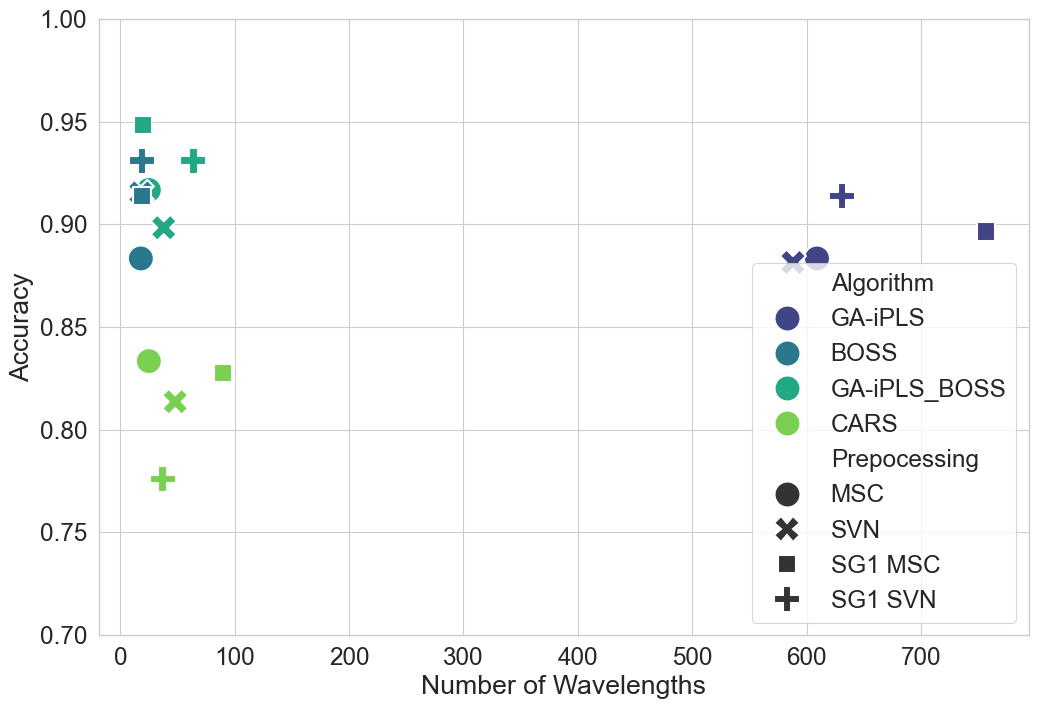

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate accuracy
def calculate_accuracy(data, w, Algorithm):
    accuracies = []
    for key, value in data.items():
        # Calculate accuracy as the ratio of correct predictions to total predictions
        accuracy = (value[0][0] + value[1][1]) / (value[0][0] + value[0][1] + value[1][0] + value[1][1])
        accuracies.append([Algorithm, key, w[key], accuracy])
    return accuracies

accuracis = calculate_accuracy(data_MSC, w_MSC, "MSC")
accuracis.extend(calculate_accuracy(data_SVN, w_SVN, "SVN"))
accuracis.extend(calculate_accuracy(data_SG1_MSC, w_SG1_MSC, "SG1 MSC"))
accuracis.extend(calculate_accuracy(data_SG1_SVN, w_SG1_SVN, "SG1 SVN"))

df = pd.DataFrame(accuracis, columns=["Prepocessing", "Algorithm", "Wavelengths", "Accuracy"])

# Filter out rows with Wavelengths = 2101
filtered_df = df[df["Wavelengths"] != 2101]

# Ensure the directory for saving plots exists
os.makedirs("plots", exist_ok=True)

# Increase font size and figure size for the plot
plt.figure(figsize=(12, 8))
sns.set_style('whitegrid')
sns.set_context("paper", font_scale=2)

# Create scatter plot with seaborn
sns.scatterplot(data=filtered_df, x="Wavelengths", y="Accuracy", hue="Algorithm", style="Prepocessing", s=350, palette='viridis')

plt.xlabel("Number of Wavelengths")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.0)
plt.grid(True)

# Show and save the plot
plt.savefig("plots/best_accuracy_plot.pdf")

In [3]:
def plot_confusion_matrix(ax, entry, n_wavelenghts, pos_count, neg_count):
    """
    Plots the confusion matrix as a heatmap on the given Axes.
    The matrix is arranged as:
    
                     Predicted
                [0]         [1]
    Actual [0]  TP          FN 
           [1]  FP          TN
    
    A title is drawn indicating the number of wavelengths.
    The color scale is fixed with vmin=0 and vmax = max(pos_count, neg_count).
    The cell annotation text color is chosen dynamically based on the cell’s brightness.
    """    
    # matrix = np.array(entry[['Healty', 'Unhealty']].values)
    matrix = entry
    
    vmax = max(pos_count, neg_count)
    im = ax.imshow(matrix, cmap='viridis', vmin=0, vmax=vmax)
    
    # Annotate each cell with text using dynamic color based on cell brightness.
    for i in range(2):
        for j in range(2):
            value = matrix[i][j]
            norm_val = value / vmax if vmax else 0
            cell_color = cm.viridis(norm_val)
            r, g, b, _ = cell_color
            luminance = 0.299*r + 0.587*g + 0.114*b
            text_color = 'white' if luminance < 0.5 else 'black'
            ax.text(j, i, f"{value}", ha='center', va='center', color=text_color, fontsize=18)
    
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_title(f"{n_wavelenghts}", fontsize=20)
    return im

def plot_all_groups(type_data, pos_count, neg_count, pdf_filename):
    # Set desired method order
    method_order = ["PLS", "SVM", "CARS", "GA-iPLS", "BOSS", "GA-iPLS_BOSS"]
    model_groups = [m for m in method_order if m in type_data]
    group_number = len(model_groups)
    n_cols = 3
    n_rows = group_number // n_cols
    if group_number % n_cols != 0:
        n_rows += 1
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3.5*n_rows))
    axs = np.array(axs)
    ims = []  # Collect image handles for colorbar scaling
    
    for i, method in enumerate(model_groups):
        r = i // n_cols
        c = i % n_cols
        ax = axs[r, c]
        ax.grid(False)
        im = plot_confusion_matrix(ax, type_data[method], method, pos_count, neg_count)
        print(method)
        print(type_data[method])
        ims.append(im)
        # Set x tick labels on the last row only.
        if r == n_rows - 1:
            ax.set_xticklabels(["Control", f"Water\nStressed"], rotation=45, ha='right', fontsize=18)
        else:
            ax.set_xticklabels([])
        # Set y tick labels on the first column only.
        if c == 0:
            ax.set_yticklabels(["Control", f"Water\nStressed"], fontsize=18)
        else:
            ax.set_yticklabels([])
    
    # Hide unused axes (removes white axis in the middle)
    for j in range(group_number, n_rows * n_cols):
        r = j // n_cols
        c = j % n_cols
        axs[r, c].axis('off')
    
    # Adjust layout to leave room on the right for the colorbar.
    plt.tight_layout(rect=[0, 0, 0.85, 0.95], w_pad=0.05, h_pad=2)
    
    # Create a fixed axis for the colorbar.
    cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
    norm = colors.Normalize(vmin=0, vmax=20)
    sm = cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
    cbar.ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label('Count', fontsize=20, labelpad=10)
    
    fig.text(0.5, -0.02, 'Predicted', ha='center', fontsize=25)
    fig.text(-0.005, 0.5, 'Actual', va='center', rotation='vertical', fontsize=25)
    
    plt.savefig(pdf_filename, format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()

PLS
[[19 10]
 [ 6 25]]
SVM
[[23  6]
 [ 4 27]]
CARS
[[22  7]
 [ 3 28]]
GA-iPLS
[[24  5]
 [ 2 29]]
BOSS
[[25  4]
 [ 3 28]]
GA-iPLS_BOSS
[[24  5]
 [ 0 31]]


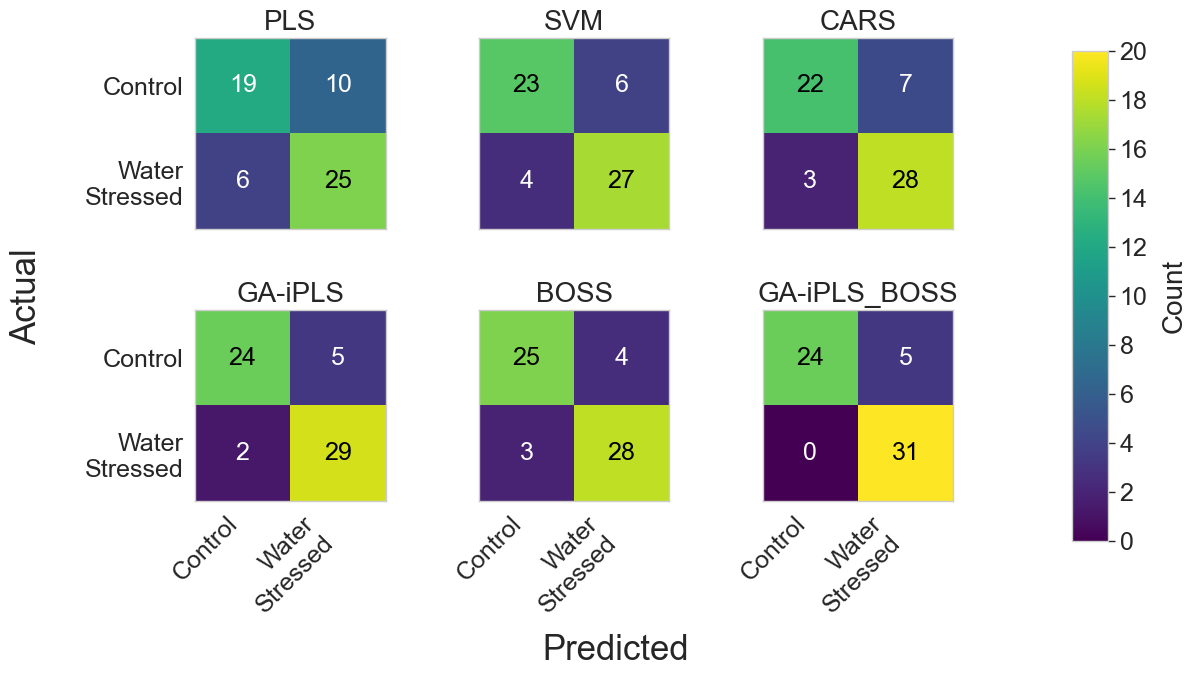

PLS
[[25  3]
 [ 6 25]]
SVM
[[19  9]
 [ 6 25]]
CARS
[[23  5]
 [ 6 25]]
GA-iPLS
[[25  3]
 [ 4 27]]
BOSS
[[26  2]
 [ 3 28]]
GA-iPLS_BOSS
[[25  3]
 [ 3 28]]


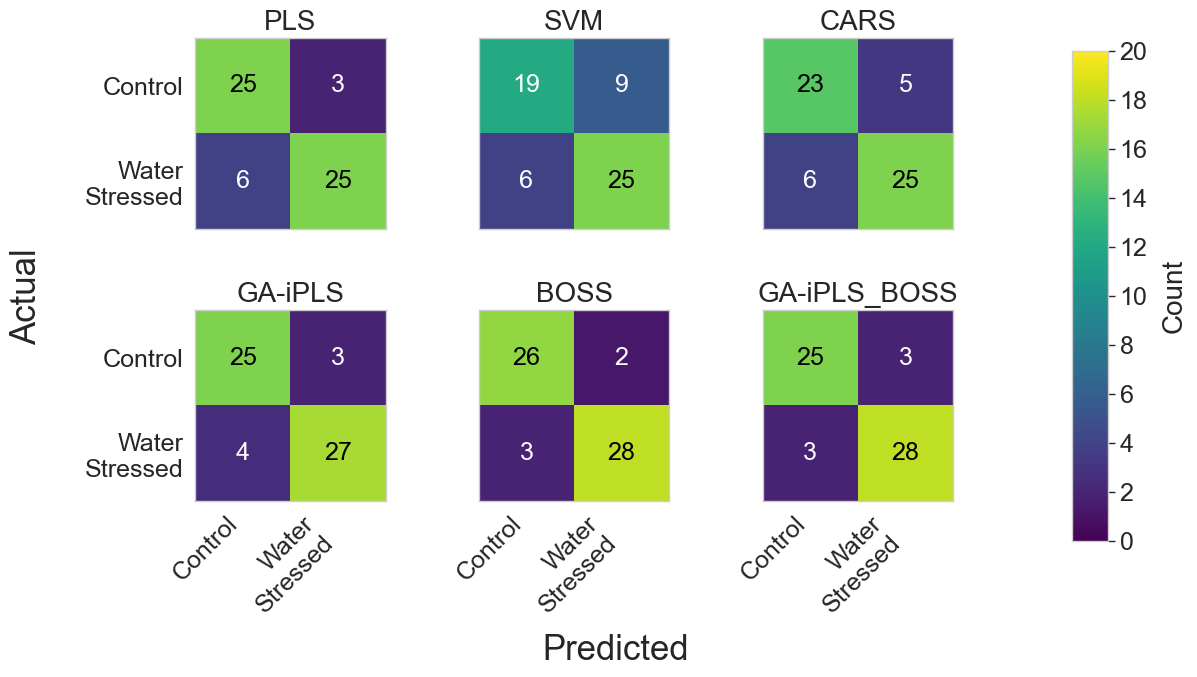

PLS
[[20  7]
 [ 4 27]]
SVM
[[17 10]
 [ 8 23]]
CARS
[[20  7]
 [ 3 28]]
GA-iPLS
[[23  4]
 [ 2 29]]
BOSS
[[23  4]
 [ 1 30]]
GA-iPLS_BOSS
[[26  1]
 [ 2 29]]


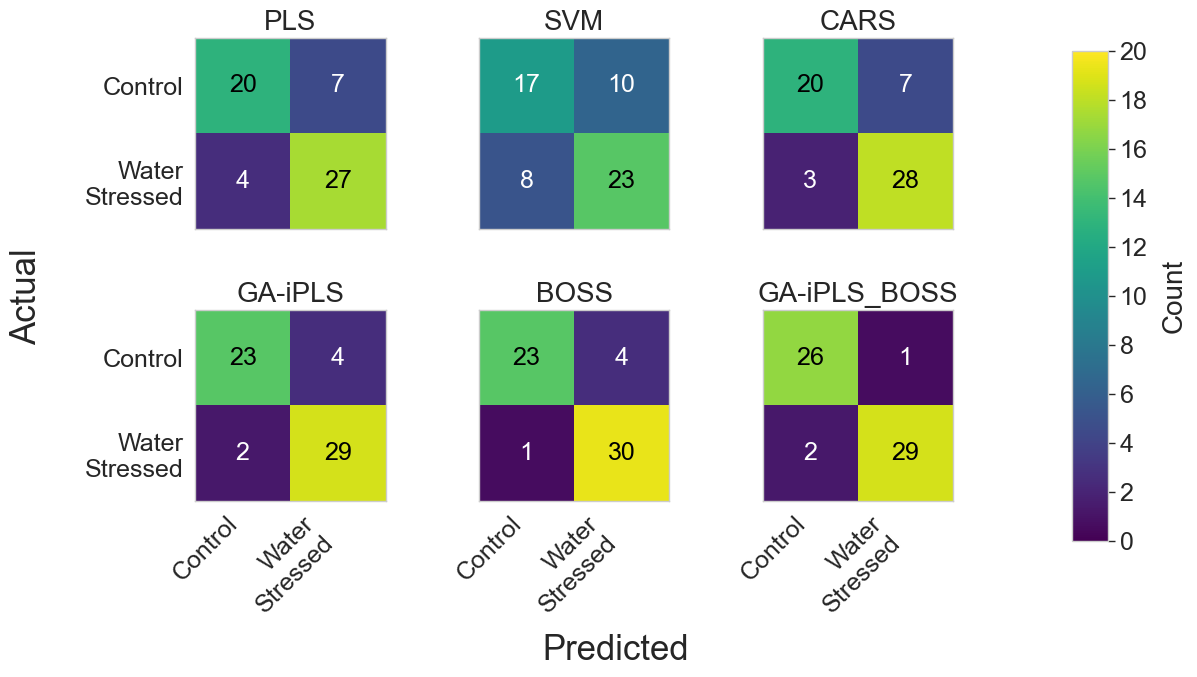

PLS
[[22  5]
 [ 5 26]]
SVM
[[21  6]
 [ 5 26]]
CARS
[[21  6]
 [ 7 24]]
GA-iPLS
[[25  2]
 [ 3 28]]
BOSS
[[25  2]
 [ 2 29]]
GA-iPLS_BOSS
[[25  2]
 [ 2 29]]


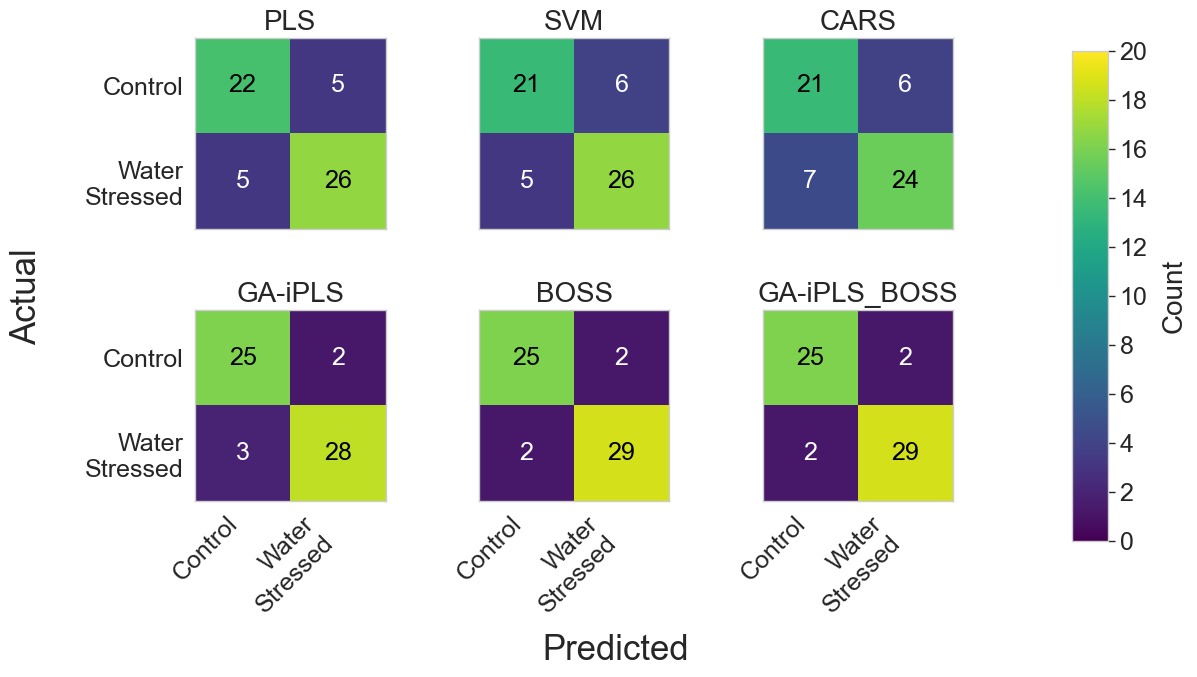

In [4]:
# Plot all confusion matrices for each method, divided by preprocessing type
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import numpy as np

# Example: set pos_count and neg_count to the maximum value in all matrices for color scaling
max_count = 0
for d in [data_SVN, data_MSC]:
    for mat in d.values():
        max_count = max(max_count, np.max(mat))

# Plot for MSC
plot_all_groups(data_MSC, max_count, max_count, "plots/confusion_matrices_MSC.pdf")
# Plot for SVN
plot_all_groups(data_SVN, max_count, max_count, "plots/confusion_matrices_SVN.pdf")
# Plot for SG1 MSC
plot_all_groups(data_SG1_MSC, max_count, max_count, "plots/confusion_matrices_SG1_MSC.pdf")
# Plot for SG1 SVN
plot_all_groups(data_SG1_SVN, max_count, max_count, "plots/confusion_matrices_SG1_SVN.pdf")

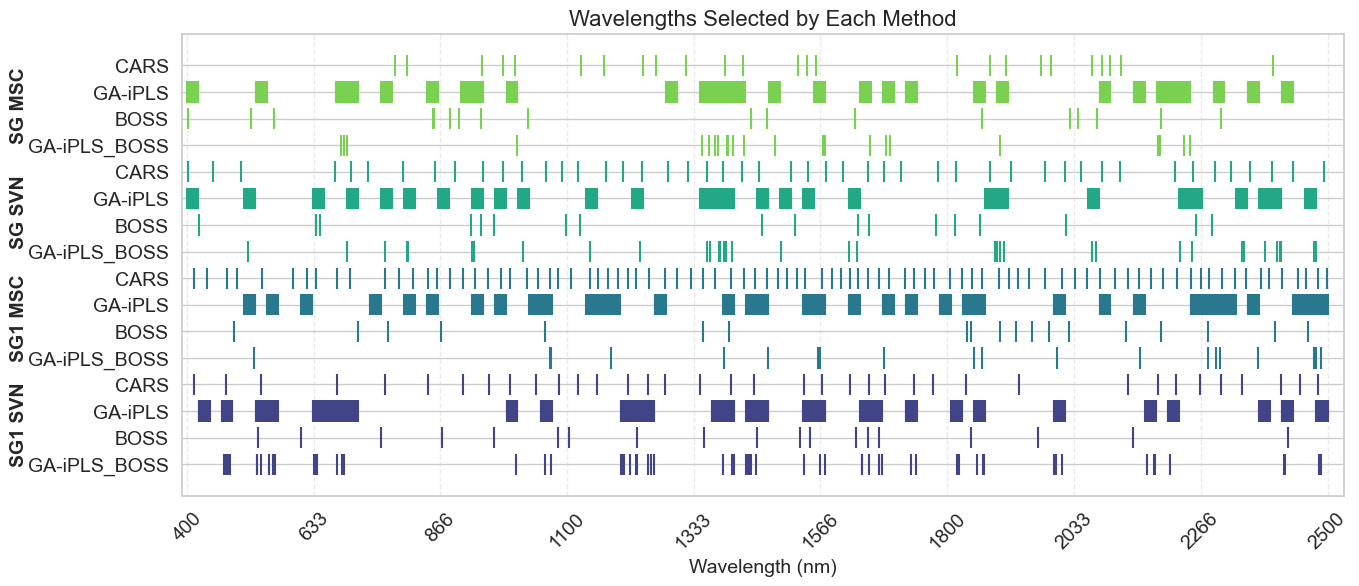

In [5]:
# Plot selected wavelengths for each method in barcode style
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Combine all wavelengths from both preprocessing types, excluding PLS and SVM
method_order = ["CARS", "GA-iPLS", "BOSS", "GA-iPLS_BOSS"]
expanded_data = {}
preprocessing_labels = []
preprocessing_bounds = [0]
short_labels = []
wavelength_range = np.arange(400, 2501)  # Example range, adjust as needed
wavelength_indices = {str(w): i for i, w in enumerate(wavelength_range)}

# Add MSC methods
for method in method_order:
    if method in wavelengths_MSC:
        expanded_data[f"SG MSC - {method}"] = wavelengths_MSC[method]
        short_labels.append(method)
preprocessing_labels.append("SG MSC")
preprocessing_bounds.append(len(expanded_data))
# Add SVN methods
for method in method_order:
    if method in wavelengths_SVN:
        expanded_data[f"SG SVN - {method}"] = wavelengths_SVN[method]
        short_labels.append(method)
preprocessing_labels.append("SG SVN")
preprocessing_bounds.append(len(expanded_data))
# Add SG1 MSC methods
for method in method_order:
    if method in wavelengths_SG1_MSC:
        expanded_data[f"SG1 MSC - {method}"] = wavelengths_SG1_MSC[method]
        short_labels.append(method)
preprocessing_labels.append("SG1 MSC")
preprocessing_bounds.append(len(expanded_data))
# Add SG1 SVN methods
for method in method_order:
    if method in wavelengths_SG1_SVN:
        expanded_data[f"SG1 SVN - {method}"] = wavelengths_SG1_SVN[method]
        short_labels.append(method)
preprocessing_labels.append("SG1 SVN")
preprocessing_bounds.append(len(expanded_data)) 

# Reverse for plotting
expanded_data_reversed = dict(reversed(list(expanded_data.items())))
short_labels_reversed = list(reversed(short_labels))

# Assign a unique color to each method group
group_colors = sns.color_palette("viridis", n_colors=len(preprocessing_labels))
group_color_map = {}
for idx, label in enumerate(preprocessing_labels):
    # Assign the same color to all methods in the same group
    start = preprocessing_bounds[idx]
    end = preprocessing_bounds[idx + 1]
    for i in range(start, end):
        group_color_map[i] = group_colors[idx]

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))
font_size = 14

for i, (label, selected_set) in enumerate(expanded_data_reversed.items()):
    x_vals = []
    for w in selected_set:
        try:
            w_int = int(float(w))
            if str(w_int) in wavelength_indices:
                x_vals.append(wavelength_indices[str(w_int)])
        except ValueError:
            continue
    color = group_color_map[i]
    plt.vlines(x=x_vals, ymin=i - 0.4, ymax=i + 0.4, color=color)

# Add preprocessing labels (MSC/SVN) further left
label_offset = -310
bounds = preprocessing_bounds[::-1]
labels = preprocessing_labels[::-1]
for idx in range(len(labels)):
    if idx + 1 < len(bounds):
        start = bounds[idx + 1]
        end = bounds[idx]
        mid_point = (len(expanded_data_reversed) - end + len(expanded_data_reversed) - start - 1) / 2
        plt.text(label_offset, mid_point, labels[idx], va='center', ha='center',
                 rotation=90, fontsize=font_size, weight='bold')

# Axis configuration
plt.yticks(range(len(expanded_data_reversed)), short_labels_reversed, fontsize=font_size)
plt.xticks(
    ticks=np.linspace(0, len(wavelength_range) - 1, 10, dtype=int),
    labels=np.linspace(min(wavelength_range), 2500, 10, dtype=int),
    rotation=45,
    fontsize=font_size
)
plt.xlabel("Wavelength (nm)", fontsize=font_size)
plt.title("Wavelengths Selected by Each Method", fontsize=font_size + 2)
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.xlim(-10, len(wavelength_range) + 30)

# Save as PDF
plt.savefig("plots/wavelength_selection_barcode_extra_margin.pdf", format='pdf', bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# Define method display names and order
methods = [
    ("PLS-DA", "PLS"),
    ("SVM", "SVM"),
    ("CARS", "CARS"),
    ("GA-iPLS", "GA-iPLS"),
    ("BOSS", "BOSS"),
    ("iGA-BOSS", "GA-iPLS_BOSS"),
]

def get_metric(metrics, w, elapsed_time, method, display_name):
    m = metrics.get(method, {})
    num_wav = w.get(method, "--")
    num_lv = m.get("nLV", "--") if "nLV" in m else ("--" if display_name == "SVM" else m.get("LV", "--"))
    acc = m.get("accuracy", "0")
    recall = m.get("recall", "0")
    prec = m.get("precision", "0")
    f1 = m.get("f1", "--")
    specificity = m.get("specificity", "--")
    time = elapsed_time.get(method, "0")
    if time == 0:
        time = "--"
    # Accuracy per wavelength
    acc_per_wav = round(acc / num_wav, 5) if isinstance(acc, float) and isinstance(num_wav, int) and num_wav > 0 else "--"
    return f"& {display_name} & {num_wav} & {num_lv} & {float(acc):.2f} & {float(recall):.2f} & {float(prec):.2f} & {float(f1):.2f} & {float(specificity):.2f} & {acc_per_wav} & {time} \\\\"

print(r"""
\begin{table}[th!]
\centering
\setlength\tabcolsep{2.5pt}
\renewcommand{\thetable}{\Roman{table}}
\renewcommand{\arraystretch}{1.3}
\begin{tabular}{
    |>{\centering\arraybackslash}m{0.7cm}
    |>{\centering\arraybackslash}m{1.7cm}
    |>{\centering\arraybackslash}m{1.3cm}
    |>{\centering\arraybackslash}m{0.9cm}
    |>{\centering\arraybackslash}m{1.0cm}
    |>{\centering\arraybackslash}m{1.0cm}
    |>{\centering\arraybackslash}m{1.0cm}
    |>{\centering\arraybackslash}m{1.0cm}
    |>{\centering\arraybackslash}m{1.0cm}
    |>{\centering\arraybackslash}m{1.5cm}
    |>{\centering\arraybackslash}m{1.5cm}|
}
    \hhline{~|----------}
    \multicolumn{1}{c|}{} &
    \cellcolor{Mycolor2} \textcolor{Mycolor3}{Algo.} &
    \cellcolor{Mycolor2} \textcolor{Mycolor3}{\#Wav.} &
    \cellcolor{Mycolor2} \textcolor{Mycolor3}{\#LV} &
    \cellcolor{Mycolor2} \textcolor{Mycolor3}{Acc.} &
    \cellcolor{Mycolor2} \textcolor{Mycolor3}{Rec.} &
    \cellcolor{Mycolor2} \textcolor{Mycolor3}{Prec.} &
    \cellcolor{Mycolor2} \textcolor{Mycolor3}{F1} &
    \cellcolor{Mycolor2} \textcolor{Mycolor3}{Spec.} &
    \cellcolor{Mycolor2} \thead{\textcolor{Mycolor3}{Acc./}\\\textcolor{Mycolor3}{Wave.}} &
    \cellcolor{Mycolor2} \thead{\textcolor{Mycolor3}{Comput.}\\\textcolor{Mycolor3}{Time}} \\
    \hline
    \multicolumn{1}{|c|}{\multirow{6}{*}{\rotatebox{90}{\textbf{SG + MSC}}}}
""")
for display_name, method in methods:
    print(get_metric(metrics_MSC, w_MSC, elapsed_MSC, method, display_name))
print(r"""    \hline
    \multicolumn{1}{|c|}{\multirow{6}{*}{\rotatebox{90}{\textbf{SG + SNV}}}}
""")
for display_name, method in methods:
    print(get_metric(metrics_SVN, w_SVN, elapsed_SVN, method, display_name))
print(r"""    \hline
    \multicolumn{1}{|c|}{\multirow{6}{*}{\rotatebox{90}{\textbf{SG1 + MSC}}}}
""")
for display_name, method in methods:
    print(get_metric(metrics_SG1_MSC, w_SG1_MSC, elapsed_SG1_MSC, method, display_name))
print(r"""    \hline
    \multicolumn{1}{|c|}{\multirow{6}{*}{\rotatebox{90}{\textbf{SG1 + SNV}}}}
""")
for display_name, method in methods:
    print(get_metric(metrics_SG1_SVN, w_SG1_SVN, elapsed_SG1_SVN, method, display_name))   

print(r"""\hline
\end{tabular}
\caption{Test set classification performance across different preprocessing pipelines, feature selection algorithms, and classification models (PLS-DA, SVM). Metrics: Accuracy, Recall, Precision, F1-score, Specificity, Accuracy per Wavelength, and Computational Time.}
\label{tab:results}
\end{table}
""")


\begin{table}[th!]
\centering
\setlength\tabcolsep{2.5pt}
\renewcommand{\thetable}{\Roman{table}}
\renewcommand{\arraystretch}{1.3}
\begin{tabular}{
    |>{\centering\arraybackslash}m{0.7cm}
    |>{\centering\arraybackslash}m{1.7cm}
    |>{\centering\arraybackslash}m{1.3cm}
    |>{\centering\arraybackslash}m{0.9cm}
    |>{\centering\arraybackslash}m{1.0cm}
    |>{\centering\arraybackslash}m{1.0cm}
    |>{\centering\arraybackslash}m{1.0cm}
    |>{\centering\arraybackslash}m{1.0cm}
    |>{\centering\arraybackslash}m{1.0cm}
    |>{\centering\arraybackslash}m{1.5cm}
    |>{\centering\arraybackslash}m{1.5cm}|
}
    \hhline{~|----------}
    \multicolumn{1}{c|}{} &
    \cellcolor{Mycolor2} \textcolor{Mycolor3}{Algo.} &
    \cellcolor{Mycolor2} \textcolor{Mycolor3}{\#Wav.} &
    \cellcolor{Mycolor2} \textcolor{Mycolor3}{\#LV} &
    \cellcolor{Mycolor2} \textcolor{Mycolor3}{Acc.} &
    \cellcolor{Mycolor2} \textcolor{Mycolor3}{Rec.} &
    \cellcolor{Mycolor2} \textcolor{Mycolor3}{Prec.} &
   

In [7]:
import re
def merge_ranges(wavelengths):
    w_ints = sorted(set(int(float(w)) for w in wavelengths if re.match(r'^\d+(\.\d+)?$', w)))
    if not w_ints:
        return "--"
    ranges = []
    start = prev = w_ints[0]
    for w in w_ints[1:]:
        if w == prev + 1:
            prev = w
        else:
            if start == prev:
                ranges.append(str(start))
            else:
                ranges.append(f"{start}-{prev}")
            start = prev = w
    if start == prev:
        ranges.append(str(start))
    else:
        ranges.append(f"{start}-{prev}")
    return ", ".join(ranges)

def latex_wavelength_table():
    method_order = [
        ("CARS", "CARS"),
        ("GA-iPLS", "GA-iPLS"),
        ("BOSS", "BOSS"),
        ("GA-iPLS_BOSS", "GA-iPLS_BOSS"),
    ]
    group_labels = [
        ("SG + MSC", wavelengths_MSC),
        ("SG + SNV", wavelengths_SVN),
        ("SG1 + MSC", wavelengths_SG1_MSC),
        ("SG1 + SNV", wavelengths_SG1_SVN),
    ]
    print(r"""
\begin{table}[th!]
\centering
\setlength\tabcolsep{5.6pt}
\renewcommand{\thetable}{\Roman{table}}
\renewcommand{\arraystretch}{1.3}
\begin{tabular}{|m{1.6cm}|c|m{15.4cm}|}
    \hhline{~|--}
    \multicolumn{1}{c|}{}&
    \cellcolor{Mycolor2} \textcolor{Mycolor3}{Algorithm} &
    \cellcolor{Mycolor2} \textcolor{Mycolor3}{Wavelengths} \\
    \hline
""")
    for group_name, group_dict in group_labels:
        for idx, (display_name, method_key) in enumerate(method_order):
            wlist = group_dict.get(method_key, [])
            if wlist:
                merged = merge_ranges(wlist)
            else:
                merged = "--"
            algo_name = display_name if display_name != "GA-iPLS_BOSS" else "\\thead{GA-iPLS\\\\+ BOSS}"
            if idx == 0:
                # Multirow only on first method
                first_col = f"\\multirow{{{len(method_order)}}}{{*}}{{\\rotatebox{{90}}{{\\textbf{{{group_name}}}}}}}"
            else:
                first_col = ""
            line = f"    {first_col} & {algo_name} & {merged} \\\\"
            if idx < len(method_order) - 1:
                line += " \\hhline{{~--}}"
            print(line)
        print("    \\hline")
    print(r"""
\end{tabular}
\caption{Wavelengths selected by each feature selection method under all preprocessing pipelines. Ranges (e.g., 1000–1020) denote contiguous spectral intervals, while comma-separated values represent individual selected wavelengths.}
\label{tab:wavelenghts}
\end{table}
""")

latex_wavelength_table()


\begin{table}[th!]
\centering
\setlength\tabcolsep{5.6pt}
\renewcommand{\thetable}{\Roman{table}}
\renewcommand{\arraystretch}{1.3}
\begin{tabular}{|m{1.6cm}|c|m{15.4cm}|}
    \hhline{~|--}
    \multicolumn{1}{c|}{}&
    \cellcolor{Mycolor2} \textcolor{Mycolor3}{Algorithm} &
    \cellcolor{Mycolor2} \textcolor{Mycolor3}{Wavelengths} \\
    \hline

    \multirow{4}{*}{\rotatebox{90}{\textbf{SG + MSC}}} & CARS & 783, 804, 943, 981, 1003, 1125, 1168, 1239, 1264, 1318, 1390, 1423, 1524, 1541, 1558, 1817, 1878, 1907, 1973, 1991, 2067, 2085, 2100, 2120, 2399 \\ \hhline{{~--}}
     & GA-iPLS & 400-420, 526-546, 673-714, 757-777, 841-861, 904-945, 988-1008, 1282-1302, 1345-1428, 1471-1491, 1555-1575, 1639-1659, 1681-1701, 1723-1743, 1849-1869, 1891-1911, 2080-2100, 2143-2163, 2185-2247, 2290-2310, 2353-2373, 2416-2436 \\ \hhline{{~--}}
     & BOSS & 401, 518, 560, 852, 854, 884, 901, 940, 1027, 1438, 1467, 1630, 1863, 2026, 2041, 2076, 2194, 2304 \\ \hhline{{~--}}
     & \thead{GA-iPLS\\+ BOS

In [8]:
def latex_wavelength_tables_separate():
    method_order = [
        ("CARS", "CARS"),
        ("GA-iPLS", "GA-iPLS"),
        ("BOSS", "BOSS"),
        ("GA-iPLS_BOSS", "GA-iPLS_BOSS"),
    ]
    group_labels = [
        ("SG + MSC", wavelengths_MSC),
        ("SG + SNV", wavelengths_SVN),
        ("SG1 + MSC", wavelengths_SG1_MSC),
        ("SG1 + SNV", wavelengths_SG1_SVN),
    ]
    for group_name, group_dict in group_labels:
        print(r"""
\begin{table}[th!]
\centering
\setlength\tabcolsep{5.6pt}
\renewcommand{\thetable}{\Roman{table}}
\renewcommand{\arraystretch}{1.3}
\begin{tabular}{|c|m{10.4cm}|}
    \hline
    \cellcolor{Mycolor2} \textcolor{Mycolor3}{Algorithm} &
    \cellcolor{Mycolor2} \textcolor{Mycolor3}{Wavelengths} \\
    \hline
""")
        for idx, (display_name, method_key) in enumerate(method_order):
            wlist = group_dict.get(method_key, [])
            if wlist:
                merged = merge_ranges(wlist)
            else:
                merged = "--"
            algo_name = display_name if display_name != "GA-iPLS_BOSS" else "\\thead{GA-iPLS\\\\+ BOSS}"
            line = f"{algo_name} & {merged} \\\\"
            if idx < len(method_order) - 1:
                line += " \\hline"
            print(line)
        print("    \\hline")
        print("\end{tabular}")
        print(rf"""\caption{{Wavelengths selected by each feature selection method under {group_name} preprocessing. Ranges (e.g., 1000–1020) denote contiguous spectral intervals, while comma-separated values represent individual selected wavelengths.}}
        \label{{tab:wavelenghts_{group_name.replace(' ', '_').replace('+', '').replace('-', '').replace('SG', 'sg').lower()}}}""")
        print("\end{table}")
        print("\n")

latex_wavelength_tables_separate()


\begin{table}[th!]
\centering
\setlength\tabcolsep{5.6pt}
\renewcommand{\thetable}{\Roman{table}}
\renewcommand{\arraystretch}{1.3}
\begin{tabular}{|c|m{10.4cm}|}
    \hline
    \cellcolor{Mycolor2} \textcolor{Mycolor3}{Algorithm} &
    \cellcolor{Mycolor2} \textcolor{Mycolor3}{Wavelengths} \\
    \hline

CARS & 783, 804, 943, 981, 1003, 1125, 1168, 1239, 1264, 1318, 1390, 1423, 1524, 1541, 1558, 1817, 1878, 1907, 1973, 1991, 2067, 2085, 2100, 2120, 2399 \\ \hline
GA-iPLS & 400-420, 526-546, 673-714, 757-777, 841-861, 904-945, 988-1008, 1282-1302, 1345-1428, 1471-1491, 1555-1575, 1639-1659, 1681-1701, 1723-1743, 1849-1869, 1891-1911, 2080-2100, 2143-2163, 2185-2247, 2290-2310, 2353-2373, 2416-2436 \\ \hline
BOSS & 401, 518, 560, 852, 854, 884, 901, 940, 1027, 1438, 1467, 1630, 1863, 2026, 2041, 2076, 2194, 2304 \\ \hline
\thead{GA-iPLS\\+ BOSS} & 683, 688, 695, 1007, 1347, 1361, 1372, 1378, 1394-1395, 1405, 1426, 1482, 1570, 1574, 1657-1658, 1687, 1695, 1897, 2187, 2190, 2192, 2235, 2